In [1]:
%matplotlib inline

import sys
import numpy as np
from numpy import linalg
import pandas as pd
import scipy as sp
from scipy import cluster
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import math
import pickle
import pystan as ps
import stan_utility

In [2]:
import os

_DATA_DIRECTORY = 'data/'

def full_path(path):
    return os.path.join(_DATA_DIRECTORY, path)

In [113]:
# Some utility functions

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Data Mettle Blue',
    [(0.28205128, 0.87179487, 1.0), (0.09401709, 0.29059829, 0.33333333)]
)

def getbins(x, n):
    return min(x) + np.linspace(0, 1, n) * (max(x) - min(x))

def hist(x, n, alpha=1.0):
    plt.hist(x, bins=getbins(x, n), alpha=alpha)

def heatmap(data, row_clusters, column_clusters, title=""):
    fit_data = data.values[np.argsort(row_clusters)]
    fit_data = fit_data[:, np.argsort(column_clusters)]
    
    plt.matshow(fit_data, cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

def write_pickle(d, path):
    with open(path, 'wb') as file:
        pickle.dump(d, file)

def read_pickle(path):
    with open(path, 'rb') as file:
        return pickle.load(file)

In [99]:
eurovision = pd.read_csv(full_path('eurovision_all.csv'))
eurovision.head()

Year Stage Jury or Televoting From country To country  Points
0  1975     f                  J      Belgium    Belgium       0
1  1975     f                  J      Belgium    Finland       0
2  1975     f                  J      Belgium     France       2
3  1975     f                  J      Belgium    Germany       0
4  1975     f                  J      Belgium    Ireland      12

Let $r_{c_ic_jy_k}$ denote the fraction of people in country $c_i$ that voted for country $c_j$ in the year $y_k$. Note that
$\sum_{j=1}^Nr_{c_ic_jy_k} = 1$, so we model the vector
$\mathbf{r}_{c_iy_k} = (r_{c_ic_1y_k}, \dots, r_{c_ic_Ny_k})$ as following a
[Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution)

$$\mathbf{r}_{c_iy_k} \sim \operatorname{Dir}(B_{c_iy_k})$$.

We choose a model where the parameters

$$B_{c_iy_k} = (\beta_{c_ic_1y_k}, \dots, \beta_{c_ic_Ny_k})$$

decompose as

$$\beta_{c_ic_jy_k} = \operatorname{Exp}\bigl(\theta_{c_iy_j} + \phi_{c_ic_j}\bigr),$$

where $\theta_{c_iy_j}$ captures the objective quality of the song from country $c_i$ in the year $y_k$, and $\phi_{c_ic_j}$ captures the bias country $c_i$ has in voting (or not voting) for country $c_j$. Furthermore, we assume that $\theta$ and $\phi$ are drawn from an (unknown) normal distribution:

$$
    \theta_{c_iy_j}\sim N(\mu, \sigma),
$$
$$
    \phi_{c_ic_j}\sim N(\mu, \sigma).
$$

Note that we don't actually have access to $r_{c_ic_jy_k}$, we only have data on the number of points each country was awarded. But we make do with what we have and approximate $r_{c_ic_jy_k}$ by

$$
    r_{c_ic_jy_k}
    \simeq
    \frac{\text{(points awarded to country $c_j$ by country $c_i$ in the year $y_k$}) + \alpha}{(\text{total points awarded by country $c_i$ in the year $y_k$}) + N\alpha},
$$

where $\alpha$ is a constant that we set to 0.1.

It's hard to say for definite whether this is a reasonable approximation without being able to actually see the voting data, but preferences often follow [power laws](https://en.wikipedia.org/wiki/Power_law), and the decreasing sequence of points 12, 10, 8, 6, 4, 2, 1, 0, 0, 0, ... at least follow a similar shape (see below for an example with 15 countries). Note that we do completely miss out on any information about the tail, but we assume that this is mostly noise that don't contribute much anyway.

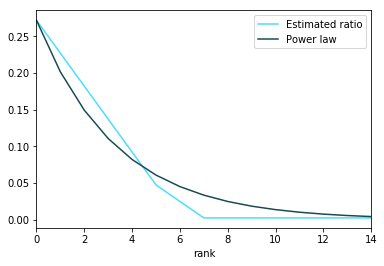

In [125]:
nr_countries = 15
alpha = 0.1
df = pd.DataFrame({'rank': range(nr_countries), 'Score': ([12, 10, 8, 6, 4, 2, 1] + [0]*(nr_countries-7))})
df['Estimated ratio'] = df['Score'].apply(lambda score: (score + 0.1) / (df['Score'].sum() + 15*alpha))
max_ratio = df['Estimated ratio'].max()
df['Power law'] = df['rank'].apply(lambda rank: max_ratio * math.exp(-0.3 * rank))

df.set_index('rank')[['Estimated ratio', 'Power law']].plot(cmap=cmap)

In [100]:
model_code = """
    data {
        int<lower=1> nr_countries;
        int<lower=1> nr_years;
        int<lower=1> nr_datapoints;
        int<lower=1> nr_slices;
        int<lower=1> max_slice_size;
        int<lower=1> slice_sizes[nr_slices];
        int<lower=1> slice_from_country[nr_slices];
        int<lower=1> slice_years[nr_slices];
        int<lower=1> to_country_index[nr_datapoints];
        vector<lower=0, upper=1>[nr_datapoints] y;
    }
    
    parameters {
        real mu;
        real<lower=1.0e-12> sigma;
        real<lower=-2> theta[nr_countries, nr_years];
        real<lower=-2> phi[nr_countries, nr_countries];
    }

    model {
        int pos;
        int slice_size;
        int from_country;
        int year;
        vector[max_slice_size] beta;
        
        for (k in 1:nr_countries) {
            for (l in 1:nr_years) {
                theta[k][l] ~ normal(mu, sigma);
            }
            for (l in 1:nr_countries) {
                phi[k][l] ~ normal(mu, sigma);
            }
        }
        
        pos = 1;
        for (s in 1:nr_slices) {
            slice_size = slice_sizes[s];
            from_country = slice_from_country[s];
            year = slice_years[s];

            // Build the Dirichlet parameters
            for (n in 1:slice_size) {
                beta[n] = exp(theta[to_country_index[pos + n - 1]][year] + phi[from_country][to_country_index[pos + n - 1]]);
            }
            
            segment(y, pos, slice_size) ~ dirichlet(segment(beta, 1, slice_size));
            
            pos = pos + slice_size;
        }
    }
"""

ps_model = ps.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b816281eddf86693ba991ba615319e45 NOW.


In [7]:
def prepare_data(df, alpha, mask):
    """
    df: A 'eurovision' dataframe.
    alpha: 
    mask: A predicate which filters the dataframe to the relevant rows.
    
    Returns: Same as the filtered df, but with a new 'Score' column.
    """
    data = (
        df[mask(df)]
        .assign(YearStage=lambda _: _['Year'].map(str) + _['Stage'])
    )

    points_by_stage = (
        data[['Year', 'Stage', 'From country', 'Points']]
        .groupby(['Year', 'Stage', 'From country'])
        .agg(sum)
        .reset_index()[['Year', 'Stage', 'Points']]
        .groupby(['Year', 'Stage'])
        .agg(max)
        .reset_index()
        .rename(columns={'Points': 'Total points'})
    )

    countries_by_stage = (
        data[['Year', 'Stage', 'From country']]
        .groupby(['Year', 'Stage', 'From country'])
        .agg(len)
        .reset_index()
        .rename(columns={0: 'Nr countries'})
    )

    data = pd.merge(data, points_by_stage)
    data = pd.merge(data, countries_by_stage)
    data['Score'] = (data['Points'] + alpha) / (data['Total points'] + alpha*data['Nr countries'])
    
    return data

In [8]:
def make_stan_dict(data):
    """
    Returns a dictionary suitable to be passed into PyStan.
    """
    countries = np.array(list(set(data['From country']).union(set(data['To country']))))
    countries_map = dict([(country, index) for index, country in enumerate(countries)])
    from_country_index = [countries_map[country] for country in data['From country']]
    to_country_index = [countries_map[country] for country in data['To country']]
    nr_countries = len(countries)
    years = data['Year'].unique()
    years_map = dict([year, index] for index, year in enumerate(years))
    year_index = [years_map[year] for year in data['Year']]
    nr_years = len(years)
    stages = data['YearStage'].unique()
    nr_stages = len(stages)

    y = []
    slice_sizes = []
    slice_from_country = []
    slice_years = []
    to_country_index = []

    for stage_i, stage in enumerate(stages):
        stage_data = data[data['YearStage'] == stage]
        year = stage_data['Year'].unique()[0]
        for from_country in stage_data['From country'].unique():
            slice_from_country.append(countries_map[from_country])
            slice_years.append(years_map[year])
            from_country_data = stage_data[stage_data['From country'] == from_country]
            slice_size = from_country_data.shape[0]
            slice_sizes.append(slice_size)
            for index, row in from_country_data.iterrows():
                y.append(row['Score'])
                to_country_index.append(countries_map[row['To country']])
    
    stan_dict = {
        'nr_countries': nr_countries,
        'nr_years': nr_years,
        'nr_datapoints': len(y),
        'nr_slices': len(slice_sizes),
        'max_slice_size': max(slice_sizes),
        'slice_sizes': slice_sizes,
        'slice_from_country': np.array(slice_from_country) + 1,
        'slice_years': np.array(slice_years) + 1,
        'to_country_index': np.array(to_country_index) + 1,
        'y': y
    }
    
    return countries, countries_map, years, years_map, stan_dict

In [9]:
# Run the PyStan sampler

data = prepare_data(eurovision,
                    alpha=0.1,
                    mask=lambda _: (_['Year'] >= 2010) & (_['Year'] <= 2015) & (_['Jury or Televoting'] == '50/50'))

countries, countries_map, years, years_map, stan_dict = make_stan_dict(data)

# This takes about 15 minutes on my machine (MacBook Pro with 2.8 GHz Intel Core i7)
fit = ps_model.sampling(data=stan_dict,
                        iter=4000,
                        chains=8,
                        control={
                            'max_treedepth': 20,
                            'adapt_delta': 0.9
                        })

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [10]:
# Extract the data from the fit
extract = fit.extract()

In [11]:
# Diagnose the fit to make sure it converged OK.
stan_utility.check_all_diagnostics(fit)

n_eff / iter looks reasonable for all parameters
Rhat looks reasonable for all parameters
0.0 of 16000 iterations ended with a divergence (0.0%)
0 of 16000 iterations saturated the maximum tree depth of 10 (0.0%)
E-BFMI indicated no pathological behavior


In [14]:
theta_mean = extract['theta'].mean(axis=0) - extract['theta'].mean()
phi_mean = extract['phi'].mean(axis=0) - extract['phi'].mean()

In [15]:
sorted([(country, theta_mean[countries_map[country], years_map[2015]])
       for country in countries],
       key=lambda _:_[1])[::-1]

[('Sweden', 1.9131248964822074),
 ('Italy', 1.8498895247017275),
 ('Russia', 1.7005043582764796),
 ('Australia', 1.4678686723825047),
 ('Belgium', 1.443818856176738),
 ('Latvia', 1.4110527600992468),
 ('Israel', 0.8303315075427321),
 ('Estonia', 0.7860830078465394),
 ('Norway', 0.7267666280549515),
 ('Georgia', 0.41180546418379826),
 ('Slovenia', 0.18102190062201334),
 ('Serbia', 0.10031153048331659),
 ('Denmark', 0.07217323466534531),
 ('Romania', 0.0502787082772195),
 ('Montenegro', 0.03891789275763152),
 ('Bulgaria', 0.011092124823549154),
 ('Bosnia & Herzegovina', 0.008042776662740836),
 ('Azerbaijan', 0.00594083283075697),
 ('Croatia', 0.004966123563015901),
 ('Turkey', 0.0021842694695592413),
 ('Ukraine', 0.0019167413142058831),
 ('Slovakia', -0.006132405366359783),
 ('Armenia', -0.017637055248460765),
 ('Lithuania', -0.01906510101920339),
 ('Greece', -0.033645235582975996),
 ('Cyprus', -0.08794798280513438),
 ('The Netherlands', -0.11839631529935707),
 ('Ireland', -0.13446137188

In [16]:
sorted([(country, phi_mean[countries_map['Malta'], countries_map[country]])
        for country in countries],
       key=lambda _:_[1])[::-1]

[('Italy', 0.9605270983912988),
 ('Azerbaijan', 0.9483283670913034),
 ('United Kingdom', 0.48840080728787894),
 ('Norway', 0.2692858871027037),
 ('Romania', 0.2640185455695536),
 ('Australia', 0.2072419288459567),
 ('Belarus', 0.19937428397236243),
 ('San Marino', 0.17110690800995643),
 ('Greece', 0.14861236172226394),
 ('Austria', 0.14301218177504854),
 ('Denmark', 0.13400062897713397),
 ('Sweden', 0.11915884469903593),
 ('Switzerland', 0.08781098604565815),
 ('Slovakia', 0.07902323443425419),
 ('Ukraine', 0.06725753592818937),
 ('Czech Republic', 0.06013427089654008),
 ('Armenia', 0.05952462093386887),
 ('Croatia', 0.03339880779996657),
 ('Israel', 0.02579307046427426),
 ('France', 0.0035606156084549423),
 ('Turkey', -0.026868451677473593),
 ('Lithuania', -0.031216733246601402),
 ('F.Y.R. Macedonia', -0.0397540298320645),
 ('Latvia', -0.041741538149226265),
 ('Ireland', -0.05414789442101836),
 ('Germany', -0.08979890302275695),
 ('Portugal', -0.1384460801374427),
 ('Bulgaria', -0.139

In [17]:
sorted([(country, extract['phi'].mean(axis=0).mean(axis=0)[countries_map[country]])
        for country in countries],
       key=lambda _:_[1])[::-1]

[('Sweden', -0.17697432926088882),
 ('Russia', -0.2089398175459393),
 ('Italy', -0.23497464656639663),
 ('Azerbaijan', -0.2378127837707762),
 ('Ukraine', -0.2460348503641747),
 ('Denmark', -0.24729565430290623),
 ('Australia', -0.25321009488696045),
 ('Greece', -0.25861487632595553),
 ('Serbia', -0.2628887946516249),
 ('Armenia', -0.26402841630105806),
 ('Romania', -0.26471717449104903),
 ('Turkey', -0.266359950524428),
 ('Belgium', -0.2669811418104635),
 ('Norway', -0.26931410243453163),
 ('Georgia', -0.27628195481837475),
 ('The Netherlands', -0.27812521111314614),
 ('Austria', -0.2826707557128787),
 ('Bosnia & Herzegovina', -0.28650887460795244),
 ('Czech Republic', -0.2876269925289473),
 ('Hungary', -0.29024276956044404),
 ('Estonia', -0.29051499151249416),
 ('Germany', -0.29113876230866803),
 ('Malta', -0.2931774760830651),
 ('Latvia', -0.2949212918902191),
 ('Israel', -0.29550574474026886),
 ('Bulgaria', -0.2970585546122622),
 ('Albania', -0.2971630751873632),
 ('Poland', -0.2991

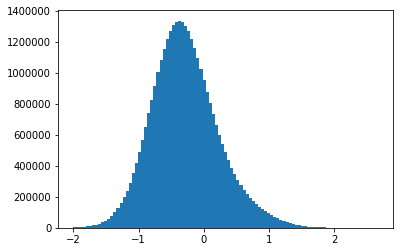

In [18]:
hist(extract['phi'].flatten(), 100)

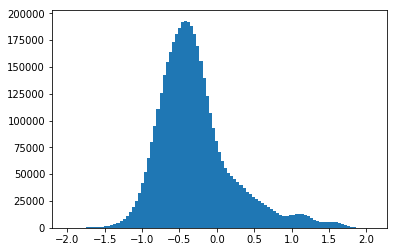

In [19]:
hist(extract['theta'].flatten(), 100)

In [25]:
# Investigate the largest biases
from_country, to_country = np.unravel_index(np.argsort(phi_mean.ravel()), phi_mean.shape)
from_country = from_country[::-1]
to_country = to_country[::-1]
for i in range(30):
    print(f'{countries[from_country[i]]} -> {countries[to_country[i]]}: {phi_mean[from_country[i]][to_country[i]]}')

Moldova -> Romania: 1.9002621831957391
Greece -> Cyprus: 1.7607140610610323
Cyprus -> Greece: 1.6199123311609358
Romania -> Moldova: 1.6023416831576829
Georgia -> Armenia: 1.5148397502554969
Armenia -> Georgia: 1.4121992050054217
Greece -> Albania: 1.4052854941691528
F.Y.R. Macedonia -> Albania: 1.384435379123727
Moldova -> Belarus: 1.3549071049560117
Turkey -> Bosnia & Herzegovina: 1.3512940345130058
Lithuania -> Georgia: 1.3417525788302174
Croatia -> Bosnia & Herzegovina: 1.316554131595431
Azerbaijan -> Georgia: 1.313953568829414
Belarus -> Ukraine: 1.3135195833930837
Moldova -> Ukraine: 1.3000520071876094
Finland -> Estonia: 1.299523015387312
Latvia -> Estonia: 1.2774518830379535
United Kingdom -> Ireland: 1.264963272567278
Ireland -> Lithuania: 1.252572542269431
Albania -> Greece: 1.2520988487811953
Georgia -> Lithuania: 1.2444506658966994
Bosnia & Herzegovina -> F.Y.R. Macedonia: 1.2315256591000516
Hungary -> Iceland: 1.2152615525618757
Russia -> Azerbaijan: 1.2137437695075655
F.Y

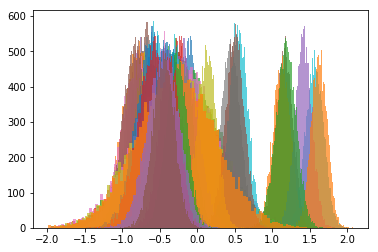

In [27]:
for country in range(len(countries)):
    hist(extract['theta'][:, country, years_map[2015]], 100, alpha=0.7)

# Clustering

Now that we have the biases between the countries, we can try and cluster the countries to see if we can identify specific groups. A suitable clustering technique is [Information Theoretic Co-Clustering](http://www.cs.utexas.edu/users/inderjit/public_papers/kdd_cocluster.pdf).

In [88]:
import importlib
import src.ITCC as itcc

importlib.reload(itcc)

phi_df = pd.DataFrame(data=phi_mean-phi_mean.min(), columns=countries, index=countries)
clusters = itcc.information_cocluster_restricted(phi_df, 3, 2)

Before greedy optimisation: 148.2341592075766.
Testing index 0, in cluster 2.
Testing index 1, in cluster 1.
Testing index 2, in cluster 1.
Testing index 3, in cluster 2.
Testing index 4, in cluster 2.
Testing index 5, in cluster 0.
Testing index 6, in cluster 1.
Found better cluster: 0 (148.10839206324025).
Testing index 0, in cluster 2.
Testing index 1, in cluster 1.
Testing index 2, in cluster 1.
Testing index 3, in cluster 2.
Testing index 4, in cluster 2.
Testing index 5, in cluster 0.
Testing index 6, in cluster 0.
Testing index 7, in cluster 1.
Testing index 8, in cluster 1.
Testing index 9, in cluster 0.
Testing index 10, in cluster 1.
Testing index 11, in cluster 2.
Found better cluster: 1 (147.72047504395252).
Testing index 0, in cluster 2.
Testing index 1, in cluster 1.
Testing index 2, in cluster 1.
Testing index 3, in cluster 2.
Testing index 4, in cluster 2.
Testing index 5, in cluster 0.
Testing index 6, in cluster 0.
Testing index 7, in cluster 1.
Testing index 8, in cl

In [89]:
clusters

array([0, 1, 2, 0, 2, 2, 2, 2, 2, 2, 1, 1, 1, 0, 1, 2, 2, 2, 2, 1, 2, 2,
       1, 1, 1, 2, 0, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 0, 1, 2, 2, 1, 1, 1,
       0, 0])

In [90]:
cluster_strengths, all_cluster_strengths = itcc.calculate_cluster_strength(phi_df, clusters)

In [91]:
pd.DataFrame({
    'Country': countries,
    'Cluster': clusters,
    'Cluster strength': cluster_strengths,
    'cluster_0': all_cluster_strengths[:, 0],
    'cluster_1': all_cluster_strengths[:, 1],
    'cluster_2': all_cluster_strengths[:, 2]
})

Country  Cluster  Cluster strength  cluster_0  cluster_1  \
0               Slovenia        0          0.048361   0.000000   3.643025   
1                 Greece        1          0.043434   2.590356   0.000000   
2        The Netherlands        2          0.055789   4.112618   3.617177   
3             Montenegro        0          0.038428   0.000000   1.811553   
4                Austria        2          0.013221   0.848483   0.983300   
5         United Kingdom        2          0.031502   3.274758   1.089984   
6               Slovakia        2          0.016209   1.423560   0.822275   
7                Iceland        2          0.064439   4.925159   4.003085   
8                 Poland        2          0.024025   2.388562   0.940236   
9                  Spain        2          0.027842   2.909287   0.948292   
10        Czech Republic        1          0.009748   1.018714   0.000000   
11            San Marino        1          0.020215   1.013949   0.000000   
12              Bulgaria        1          0.020976   1.644881   0.000000   
13  Bosnia & Herzegovina        0          0.063736   0.000000   4.255399   
14               Belarus        1          0.051856   3.695977   0.000000   
15               Belgium        2          0.049295   4.183810   2.646251   
16           Switzerland        2          0.021480   1.099572   1.876529   
17                Norway        2          0.063508   4.736247   4.063112   
18                France        2          0.011823   1.237809   0.400289   
19                 Italy        1          0.010614   0.566494   0.000000   
20              Portugal        2          0.030406   2.641858   1.570979   
21                Latvia        2          0.047489   3.908417   2.671376   
22               Armenia        1          0.053752   3.885281   0.000000   
23               Romania        1          0.035962   3.675332   0.000000   
24                Russia        1          0.037601   3.267033   0.000000   
25               Germany        2          0.039646   2.795475   2.697615   
26               Croatia        0          0.052594   0.000000   3.467041   
27               Finland        2          0.066916   5.083174   4.188342   
28               Ukraine        1          0.058926   4.083218   0.000000   
29                Israel        1          0.022125   2.228291   0.000000   
30                 Malta        1          0.030259   2.815337   0.000000   
31                Sweden        2          0.053498   4.174823   3.237528   
32             Australia        2          0.027751   2.251388   1.593639   
33               Moldova        1          0.052073   3.748769   0.000000   
34               Denmark        2          0.061470   4.830829   3.686131   
35               Estonia        2          0.067198   5.724852   3.585783   
36               Hungary        2          0.027247   2.507102   1.268128   
37                Serbia        0          0.059976   0.000000   4.130594   
38               Georgia        1          0.064433   4.669031   0.000000   
39             Lithuania        2          0.034809   3.609340   1.213625   
40               Ireland        2          0.056167   4.618297   3.163870   
41                Turkey        1          0.009255   0.354985   0.000000   
42            Azerbaijan        1          0.068798   4.183070   0.000000   
43                Cyprus        1          0.029951   2.463657   0.000000   
44      F.Y.R. Macedonia        0          0.076366   0.000000   4.142712   
45               Albania        0          0.026925   0.000000   1.049939   

    cluster_2  
0    3.057661  
1    3.427674  
2    0.000000  
3    3.512881  
4    0.000000  
5    0.000000  
6    0.000000  
7    0.000000  
8    0.000000  
9    0.000000  
10   0.331945  
11   1.786979  
12   1.261425  
13   4.575569  
14   3.488965  
15   0.000000  
16   0.000000  
17   0.000000  
18   0.000000  
19   0.904074  
20   0.000000  
21   0.000000  
22   3.562320  
23   1.307371

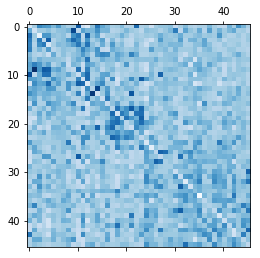

In [38]:
heatmap(phi_df, clusters, clusters)

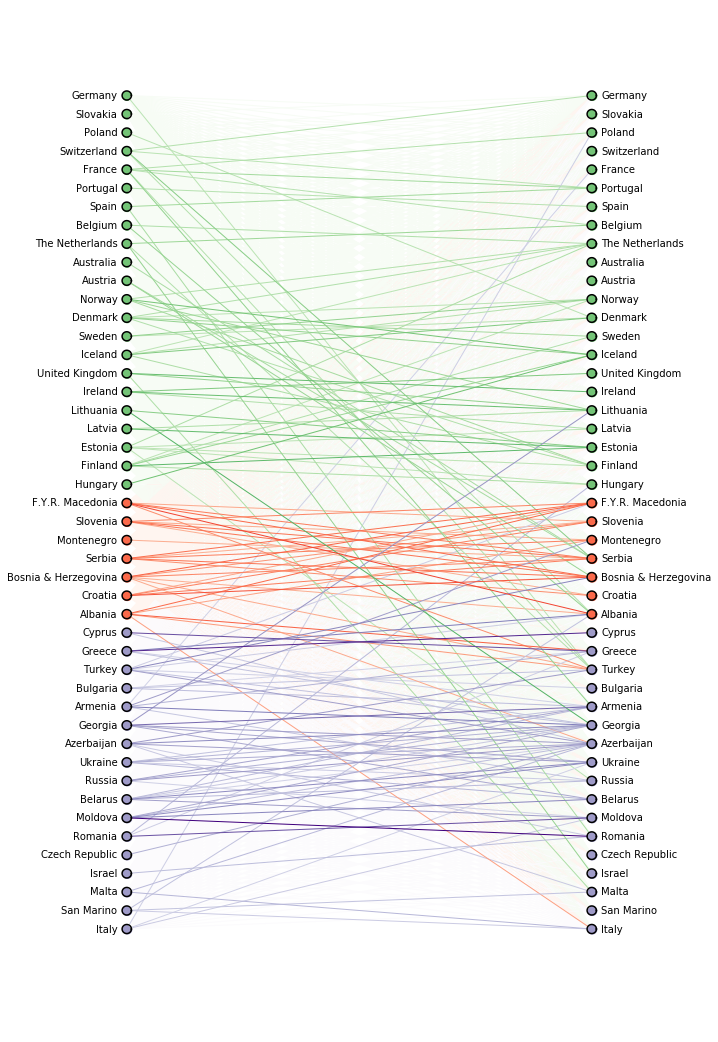

In [92]:
import src.draw as draw

importlib.reload(draw)

country_order = [
    'Italy',
    'San Marino',
    'Malta',
    'Israel',
    'Czech Republic',
    'Romania',
    'Moldova',
    'Belarus',
    'Russia',
    'Ukraine',
    'Azerbaijan',
    'Georgia',
    'Armenia',
    'Bulgaria',
    'Turkey',
    'Greece',
    'Cyprus',
    'Albania',
    'Croatia',
    'Bosnia & Herzegovina',
    'Serbia',
    'Montenegro',
    'Slovenia',
    'F.Y.R. Macedonia',
    'Hungary',
    'Finland',
    'Estonia',
    'Latvia',
    'Lithuania',
    'Ireland',
    'United Kingdom',
    'Iceland',
    'Sweden',
    'Denmark',
    'Norway',
    'Austria',
    'Australia',
    'The Netherlands',
    'Belgium',
    'Spain',
    'Portugal',
    'France',
    'Switzerland',
    'Poland',
    'Slovakia',
    'Germany'
    ]

remap = np.argsort([countries_map[country] for country in country_order])
draw.bipartite_graph(np.exp(phi_df) * (phi_df > 2.0), clusters, remap, 1.0, 1.0, 0.5)
plt.savefig('images/bipartite_graph.png', bbox_inches='tight', dpi=150)

# Maps

In [42]:
import geopandas as gpd

country_codes = pd.read_csv(full_path('country_codes.csv'))

shapefile = full_path('maps/ne_10m_admin_0_countries.shp')
shape = gpd.read_file(shapefile)
gdf = shape.to_crs("+init=epsg:3035")
gdf_australia = shape.to_crs("+init=epsg:3577")

clusters_df = pd.DataFrame(
    {
        'Country': countries,
        'cluster': clusters,
        'strength': cluster_strengths
    }
)

def merge_with_map(map_df, country_codes):
    return (
        pd.merge(map_df, country_codes)
        .replace({'Russian Federation': 'Russia',
                  'Netherlands': 'The Netherlands',
                  'Czechia': 'Czech Republic',
                  'Bosnia and Herzegovina': 'Bosnia & Herzegovina',
                  'Moldova, Republic of': 'Moldova',
                  'Macedonia, the former Yugoslav Republic of': 'F.Y.R. Macedonia'})
    )

eurovision_map = merge_with_map(gdf, country_codes)

eurovision_map_australia = merge_with_map(gdf_australia, country_codes)

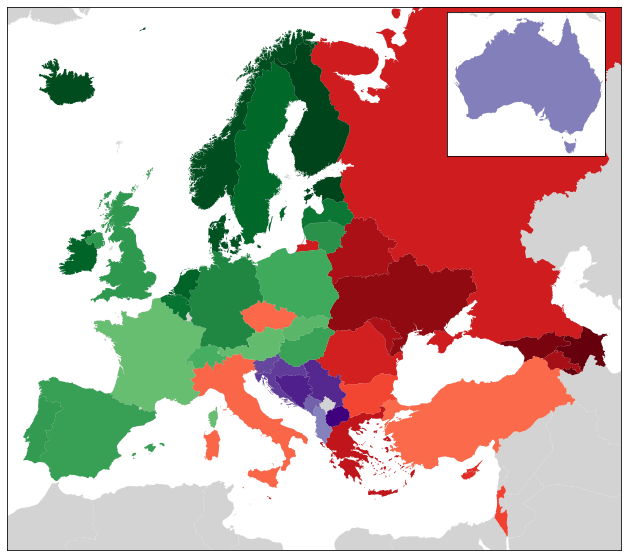

In [45]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

f, ax = plt.subplots(1, figsize=(11, 10))
f.subplots_adjust(hspace=0.0, wspace=0.0)
gdf.plot(ax=ax, color='lightgrey')

eurovision_map_cluster = pd.merge(eurovision_map, clusters_df, left_on='Country name', right_on='Country')

eurovision_map_cluster[eurovision_map_cluster['cluster'] == 0].plot(ax=ax,
                                                                    cmap='Reds',
                                                                    vmin=-0.05,
                                                                    column='strength')
eurovision_map_cluster[eurovision_map_cluster['cluster'] == 1].plot(ax=ax,
                                                                    cmap='Purples',
                                                                    vmin=-0.05,
                                                                    column='strength')
eurovision_map_australia_cluster = pd.merge(eurovision_map_australia, clusters_df, left_on='Country name', right_on='Country')
inset_ax = inset_axes(ax, 
                      width=1.5*(2.5/1.5),
                      height=1.2*(2.5/1.5),
                      loc=1)
gdf_australia.plot(ax=inset_ax, color='lightgrey')
eurovision_map_australia_cluster.plot(ax=inset_ax,
                                      cmap='Purples',
                                      vmin=-0.05,
                                      column='strength')
inset_ax.set_xlim(-0.21e7, 0.22e7)
inset_ax.set_ylim(-0.49e7, -0.1e7)
inset_ax.axes.get_xaxis().set_visible(False)
inset_ax.axes.get_yaxis().set_visible(False)

eurovision_map_cluster[eurovision_map_cluster['cluster'] == 2].plot(ax=ax,
                                                                    cmap='Greens',
                                                                    vmin=-0.05,
                                                                    column='strength')
ax.set_xlim(0.25e7, 0.77e7)
ax.set_ylim(0.10e7, 0.56e7)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.savefig('images/clusters_map.png', bbox_inches='tight', dpi=150)

# Unbiased results

In [46]:
years = []
first = []
second = []
third = []
fourth = []

for year in range(2010, 2016):
    sorted_results = sorted([(country, theta_mean[countries_map[country], years_map[year]])
                             for country in countries],
                             key=lambda _:_[1])[::-1]
    years.append(year)
    first.append(sorted_results[0][0])
    second.append(sorted_results[1][0])
    third.append(sorted_results[2][0])
    fourth.append(sorted_results[3][0])

unbiased_results = pd.DataFrame(
    {
        'Winner': first,
        'Runner-up': second,
        'Third': third,
        'Fourth': fourth
    },
    index=pd.Index([f'{year} unbiased' for year in years], name='Year')
).transpose()

In [47]:
actual_results = pd.concat([
    (
        eurovision[(eurovision['Year'] == year) & (eurovision['Stage'] == 'f')][['To country', 'Points']]
        .groupby('To country')
        .agg(sum)
        .sort_values('Points', ascending=False)
        .reset_index()
        .iloc[0:5, :]
        .assign(s=lambda _: _['To country'] + ' (' + _['Points'].astype(str) + ')')[['s']].transpose()
        .set_index(pd.Index([year], name='Year'))
        .rename(columns={
            0: 'Winner',
            1: 'Runner-up',
            2: 'Third',
            3: 'Fourth',
            4: 'Fifth'
        })
    )
    for year in range(2010, 2016)
]).iloc[:, 0:4].transpose()

In [48]:
together = pd.concat([actual_results, unbiased_results], axis=1)

In [49]:
together[[2010, '2010 unbiased']]

Year                2010 2010 unbiased
Winner     Germany (246)       Germany
Runner-up   Turkey (170)       Romania
Third      Romania (162)        Turkey
Fourth     Denmark (149)       Belgium

In [50]:
together[[2011, '2011 unbiased']]

Year                   2011 2011 unbiased
Winner     Azerbaijan (221)    Azerbaijan
Runner-up       Italy (189)        Sweden
Third          Sweden (185)         Italy
Fourth        Ukraine (159)        Greece

In [51]:
together[[2012, '2012 unbiased']]

Year                   2012 2012 unbiased
Winner         Sweden (372)        Sweden
Runner-up      Russia (259)        Russia
Third          Serbia (214)        Serbia
Fourth     Azerbaijan (150)       Albania

In [52]:
together[[2013, '2013 unbiased']]

Year                   2013 2013 unbiased
Winner        Denmark (281)       Denmark
Runner-up  Azerbaijan (234)    Azerbaijan
Third         Ukraine (214)        Norway
Fourth         Norway (191)       Ukraine

In [53]:
together[[2014, '2014 unbiased']]

Year                        2014    2014 unbiased
Winner             Austria (290)          Austria
Runner-up  The Netherlands (238)  The Netherlands
Third               Sweden (218)           Sweden
Fourth             Armenia (174)          Armenia

In [54]:
together[[2015, '2015 unbiased']]

Year                2015 2015 unbiased
Winner      Sweden (365)        Sweden
Runner-up   Russia (303)         Italy
Third        Italy (292)        Russia
Fourth     Belgium (217)     Australia

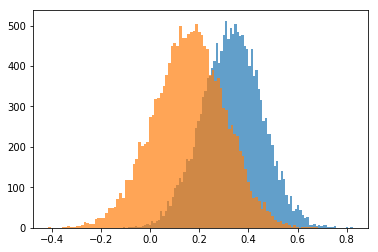

In [55]:
# Azerbaijan vs Italy 2011
hist(extract['theta'][:, countries_map['Azerbaijan'], years_map[2011]], 100, alpha=0.7)
hist(extract['theta'][:, countries_map['Italy'], years_map[2011]], 100, alpha=0.7)

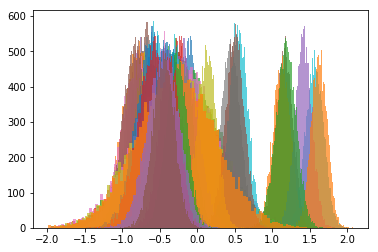

In [56]:
#for year in range(2010, 2016):
for country in countries:
    hist(extract['theta'][:, countries_map[country], years_map[2015]], 100, alpha=0.7)

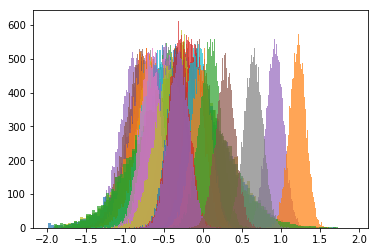

In [57]:
#for year in range(2010, 2016):
for country in countries:
    hist(extract['theta'][:, countries_map[country], years_map[2012]], 100, alpha=0.7)

# Excluding clusters

Here we explore what *would* have happened if one of our blocks wouldn't be allowed to
vote. Would it affect the end result?

In [58]:
# Merge eurovision with clusters
c_df = (
    eurovision
    .merge(
        clusters_df
        .rename(columns={'Country': 'From country'})
    )
)

# 0: East
# 1: West
# 2: Balkans

In [59]:
# No east
pd.concat([
    (
        c_df[(c_df['cluster'] != 0) & (c_df['Year'] == year) & (c_df['Stage'] == 'f')][['To country', 'Points']]
        .groupby('To country')
        .agg(sum)
        .sort_values('Points', ascending=False)
        .reset_index()
        # Take top five
        .iloc[0:5, :]
        .assign(s=lambda _: _['To country'] + ' (' + _['Points'].astype(str) + ')')[['s']].transpose()
        .set_index(pd.Index([year], name='Year'))
        .rename(columns={
            0: 'Winner',
            1: 'Runner-up',
            2: 'Third',
            3: 'Fourth',
            4: 'Fifth'
        })
    )
    for year in range(2010, 2016)
])

Winner      Runner-up             Third  \
Year                                                           
2010          Germany (208)   Turkey (124)     Belgium (117)   
2011            Italy (133)   Sweden (121)  Azerbaijan (114)   
2012           Sweden (265)   Russia (160)      Serbia (156)   
2013          Denmark (201)   Norway (126)      Russia (125)   
2014  The Netherlands (212)  Austria (205)      Sweden (155)   
2015           Sweden (248)   Russia (196)       Italy (173)   

                Fourth                       Fifth  
Year                                                
2010     Denmark (115)               Romania (109)  
2011     Ireland (108)  Bosnia & Herzegovina (106)  
2012     Estonia (107)                Germany (98)  
2013  Azerbaijan (114)       The Netherlands (109)  
2014      Armenia (99)                Hungary (87)  
2015   Australia (143)               Belgium (140)

In [60]:
# No west
pd.concat([
    (
        c_df[(c_df['cluster'] != 1) & (c_df['Year'] == year) & (c_df['Stage'] == 'f')][['To country', 'Points']]
        .groupby('To country')
        .agg(sum)
        .sort_values('Points', ascending=False)
        .reset_index()
        .iloc[0:5, :]
        .assign(s=lambda _: _['To country'] + ' (' + _['Points'].astype(str) + ')')[['s']].transpose()
        .set_index(pd.Index([year], name='Year'))
        .rename(columns={
            0: 'Winner',
            1: 'Runner-up',
            2: 'Third',
            3: 'Fourth',
            4: 'Fifth'
        })
    )
    for year in range(2010, 2016)
])

Winner              Runner-up          Third  \
Year                                                           
2010     Germany (196)          Romania (142)  Belgium (138)   
2011  Azerbaijan (195)           Sweden (165)    Italy (165)   
2012      Sweden (319)           Russia (224)   Serbia (157)   
2013     Denmark (224)       Azerbaijan (200)  Ukraine (192)   
2014     Austria (268)  The Netherlands (221)   Sweden (200)   
2015      Sweden (328)           Russia (267)    Italy (252)   

                Fourth             Fifth  
Year                                      
2010     Armenia (136)  Azerbaijan (135)  
2011     Ukraine (132)     Denmark (126)  
2012  Azerbaijan (129)     Estonia (120)  
2013      Norway (162)      Russia (137)  
2014     Armenia (156)     Hungary (113)  
2015     Belgium (208)   Australia (188)

In [61]:
# No Balkans
pd.concat([
    (
        c_df[(c_df['cluster'] != 2) & (c_df['Year'] == year) & (c_df['Stage'] == 'f')][['To country', 'Points']]
        .groupby('To country')
        .agg(sum)
        .sort_values('Points', ascending=False)
        .reset_index()
        .iloc[0:5, :]
        .assign(s=lambda _: _['To country'] + ' (' + _['Points'].astype(str) + ')')[['s']].transpose()
        .set_index(pd.Index([year], name='Year'))
        .rename(columns={
            0: 'Winner',
            1: 'Runner-up',
            2: 'Third',
            3: 'Fourth',
            4: 'Fifth'
        })
    )
    for year in range(2010, 2016)
])

Winner         Runner-up             Third        Fourth  \
Year                                                                       
2010  Azerbaijan (105)      Georgia (92)       Turkey (91)  Armenia (90)   
2011     Ukraine (136)  Azerbaijan (133)       Greece (92)   Sweden (84)   
2012      Sweden (160)      Russia (134)  Azerbaijan (129)  Serbia (115)   
2013  Azerbaijan (154)     Denmark (137)     Ukraine (136)  Greece (106)   
2014     Austria (107)      Armenia (93)      Hungary (86)   Sweden (81)   
2015       Italy (159)      Sweden (154)      Russia (143)  Belgium (86)   

             Fifth  
Year                
2010  Germany (88)  
2011  Georgia (83)  
2012  Albania (89)  
2013   Norway (94)  
2014   Russia (78)  
2015   Latvia (64)

# Winner's votes

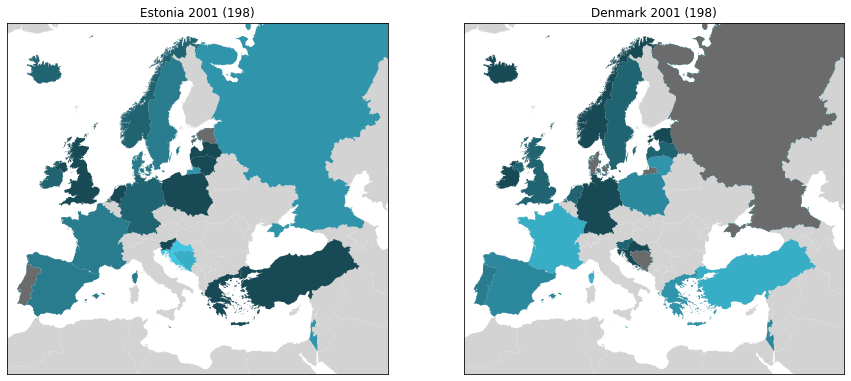

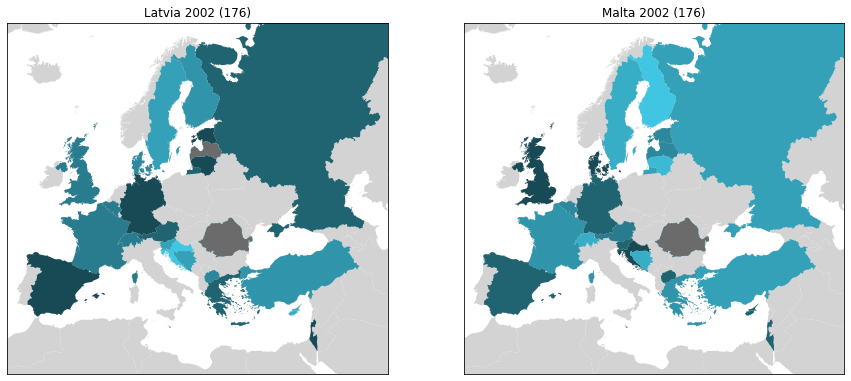

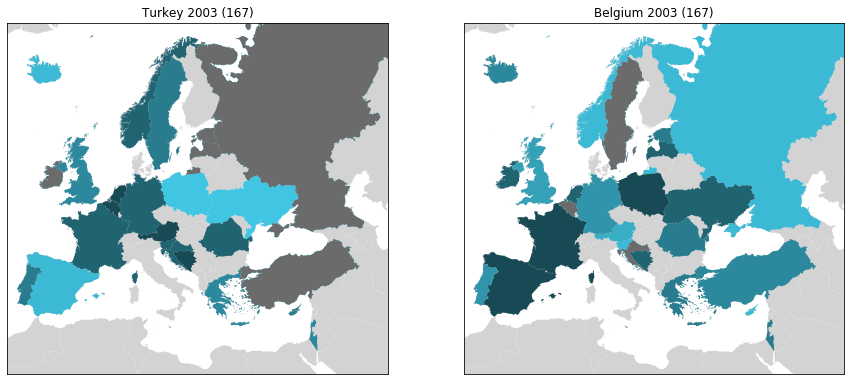

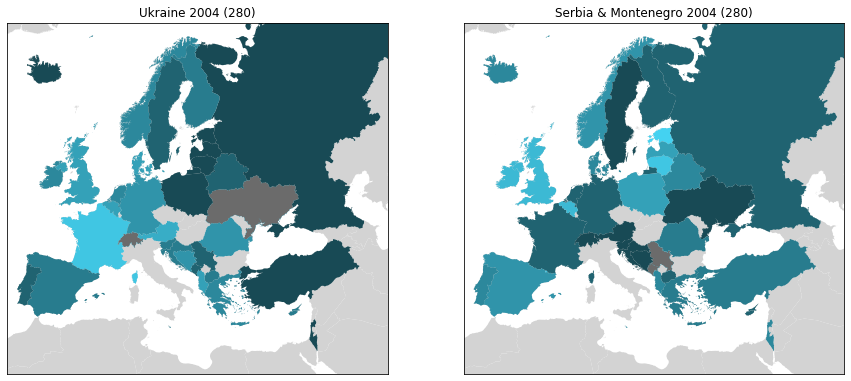

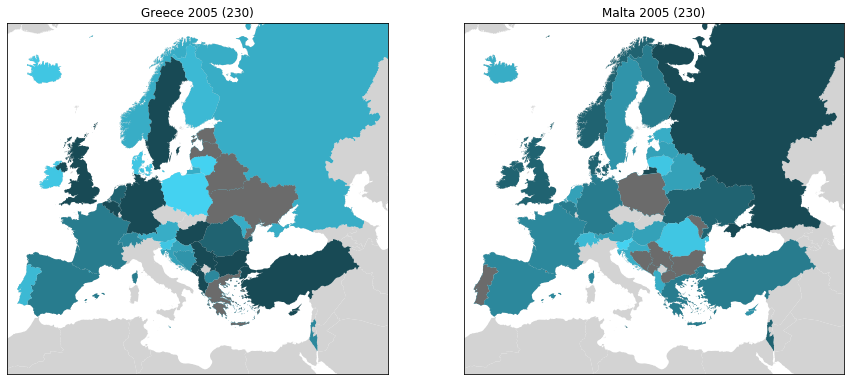

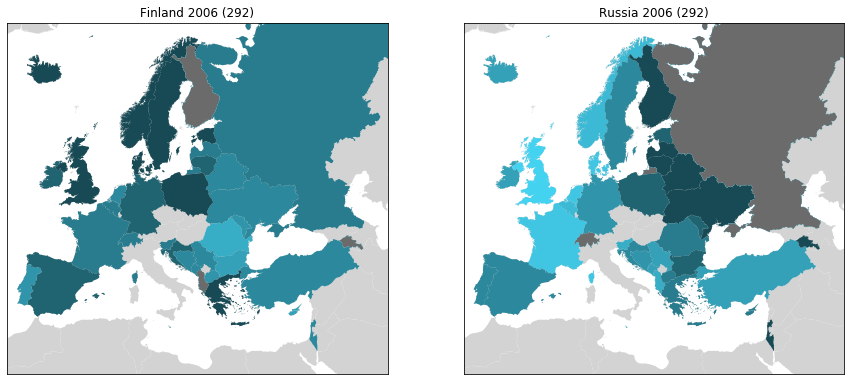

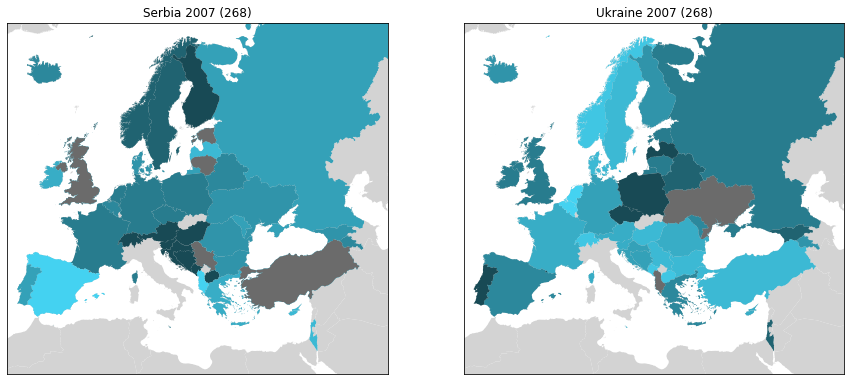

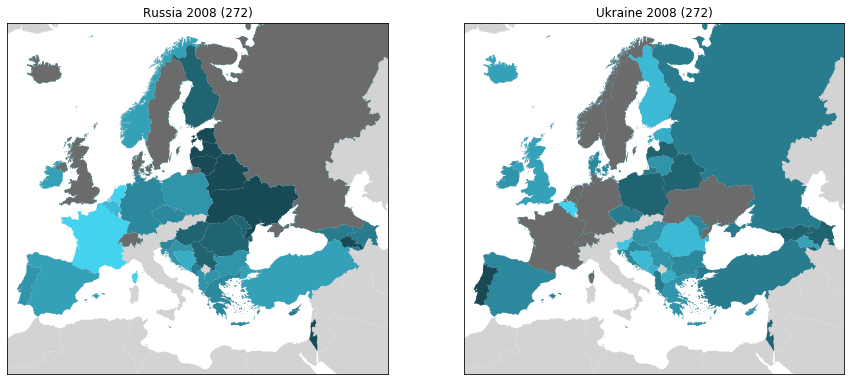

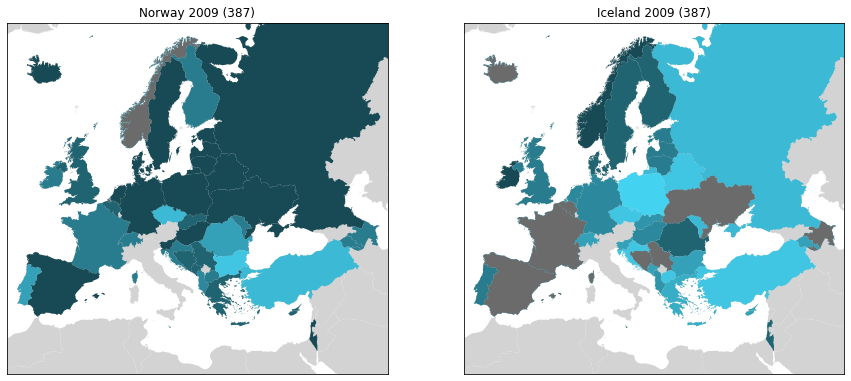

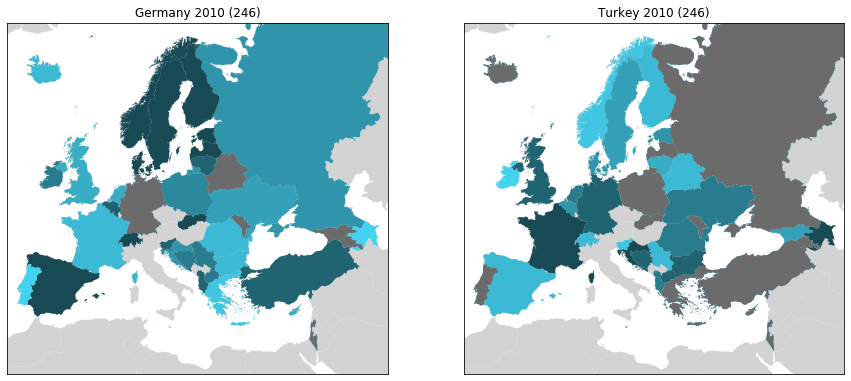

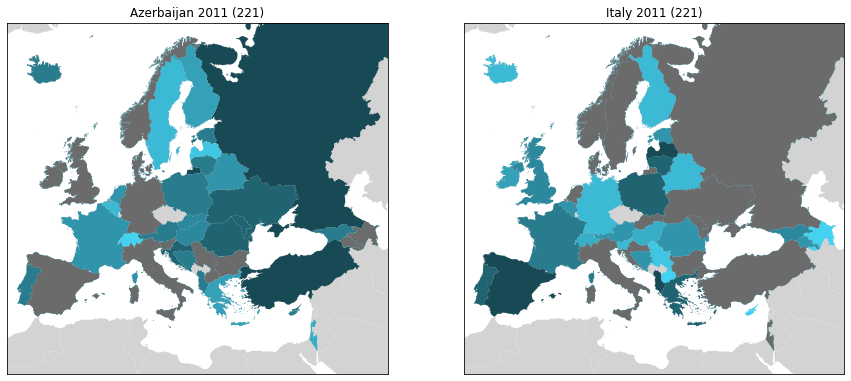

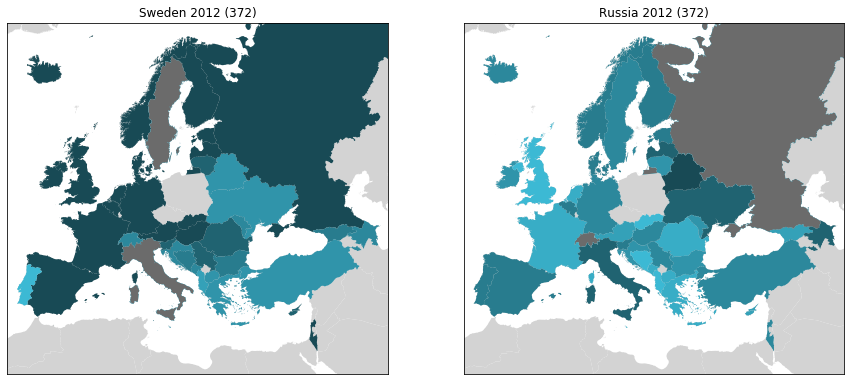

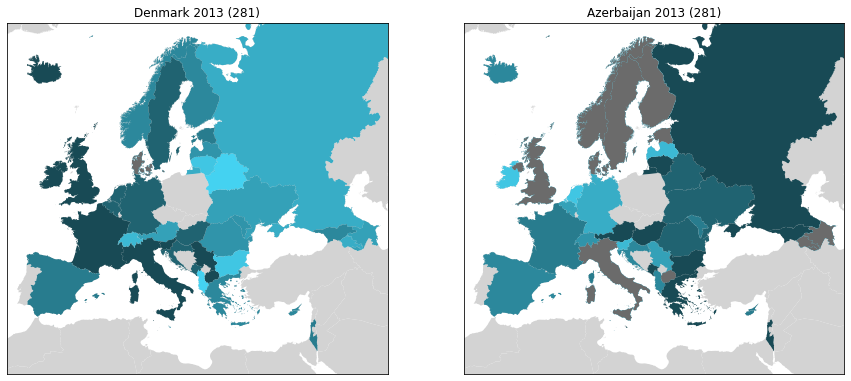

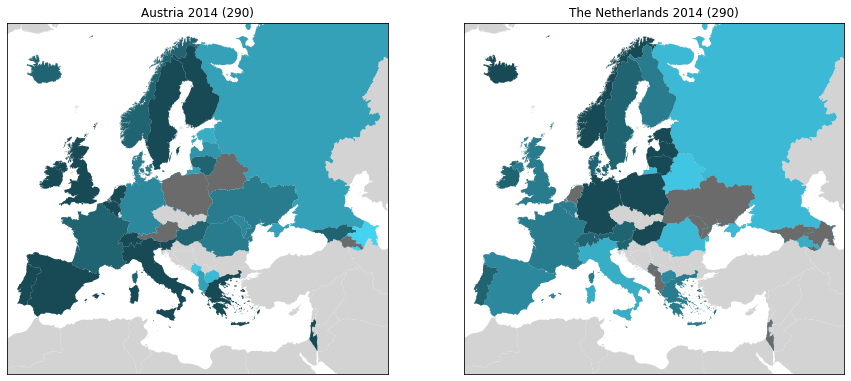

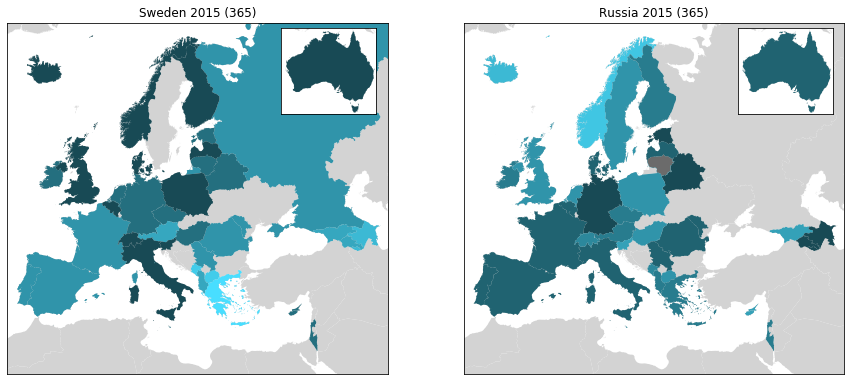

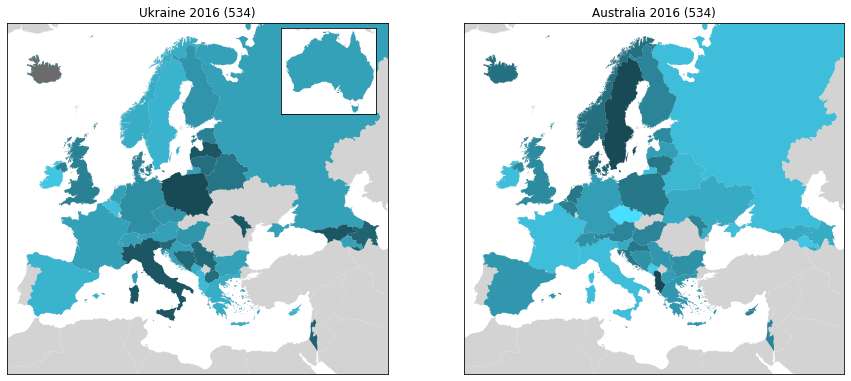

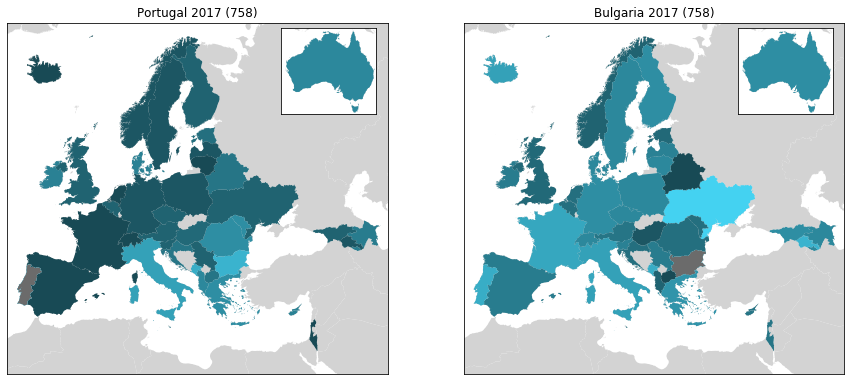

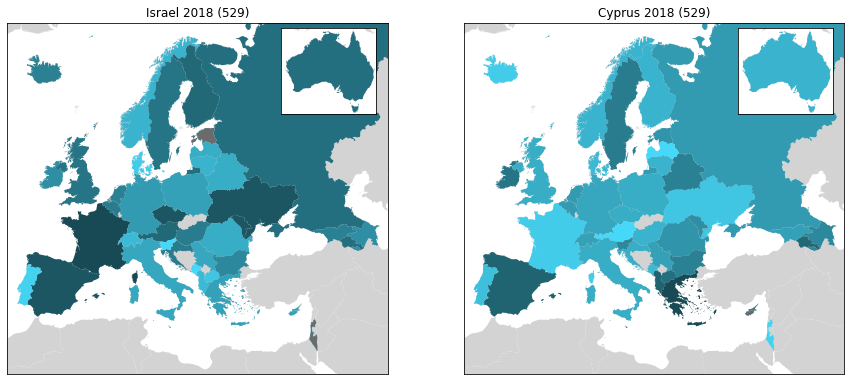

In [86]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def plot_to_votes(ax, df, year, country, points):
    """
    Plots a map showing how many points each country gave 'country' in
    the year 'year' in the final.
    """
    to_plot = (
        df[(df['To country'] == country) & (df['Year'] == year) & (df['Stage'] == 'f')][['From country', 'To country', 'Points']]
        .groupby(['From country', 'To country'])
        .sum()
        .reset_index()
    )

    eurovision_map_w = pd.merge(eurovision_map, to_plot, left_on='Country name', right_on='From country')
    
    gdf.plot(ax=ax, color='lightgrey')
    eurovision_map_w.plot(ax=ax,
                          cmap=cmap,
                          column='Points')
    zeros = eurovision_map_w[eurovision_map_w['Points'] == 0]
    if zeros.shape[0] > 0:
        zeros.plot(ax=ax, color=(np.array([107.0, 107.0, 107.0, 255.0]) / 255))

    ax.set_xlim(0.25e7, 0.77e7)
    ax.set_ylim(0.08e7, 0.56e7)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_title(f'{country} {year} ({points})')
    
    if sum(eurovision_map_w['From country'] == 'Australia') > 0:
        eurovision_map_australia_w = pd.merge(eurovision_map_australia, to_plot, left_on='Country name', right_on='From country')
        inset_ax = inset_axes(ax, 
                              width=1.5,
                              height=1.2,
                              loc=1)
        gdf_australia.plot(ax=inset_ax, color='lightgrey')
        eurovision_map_australia_w.plot(ax=inset_ax,
                                        cmap=cmap,
                                        column='Points')
        inset_ax.set_xlim(-0.21e7, 0.22e7)
        inset_ax.set_ylim(-0.49e7, -0.1e7)
        inset_ax.axes.get_xaxis().set_visible(False)
        inset_ax.axes.get_yaxis().set_visible(False)

def plot_winner_and_runner_up(df, year):
    """
    Finds the winner and runner up in year 'year', and plots maps
    showing how many points they recieved from other countries.
    """
    total_points_ordered = (
        df[(df['Year'] == year) & (df['Stage'] == 'f')][['To country', 'Points']]
        .groupby('To country')
        .sum()
        .sort_values(by='Points', ascending=False)
    )
    
    winner = total_points_ordered.index[0]
    winner_pts = total_points_ordered.iloc[0]['Points']
    runner_up = total_points_ordered.index[1]
    runner_up_pts = total_points_ordered.iloc[0]['Points']
    
    ratio = 15/6.5
    width = 15
    dpi=75
    f, ax = plt.subplots(1, 2, figsize=(width, width/ratio)) # f, ax = plt.subplots(1, figsize=(10, 10))
    plot_to_votes(ax[0], df, year, winner, winner_pts)
    plot_to_votes(ax[1], df, year, runner_up, runner_up_pts)

for year in range(2001, 2019):
    plot_winner_and_runner_up(eurovision, year)